In [1]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
import keras
from keras.layers import Dense, Conv2D, MaxPooling2D , Dropout , Flatten , BatchNormalization, Activation , Reshape, UpSampling2D
from statistics import mean
import torch

In [2]:
!unzip 'Dataset.zip'
address = ['/content/Dataset/Class 1',
       '/content/Dataset/Class 2',
       '/content/Dataset/Class 3',
       '/content/Dataset/Class 4',
       '/content/Dataset/Class 5']

Archive:  Dataset.zip
   creating: Dataset/Class 1/
 extracting: Dataset/Class 1/0.png   
 extracting: Dataset/Class 1/1.png   
 extracting: Dataset/Class 1/10.png  
 extracting: Dataset/Class 1/100.png  
 extracting: Dataset/Class 1/101.png  
 extracting: Dataset/Class 1/102.png  
 extracting: Dataset/Class 1/103.png  
 extracting: Dataset/Class 1/104.png  
 extracting: Dataset/Class 1/105.png  
 extracting: Dataset/Class 1/106.png  
 extracting: Dataset/Class 1/107.png  
 extracting: Dataset/Class 1/108.png  
 extracting: Dataset/Class 1/109.png  
 extracting: Dataset/Class 1/11.png  
 extracting: Dataset/Class 1/110.png  
 extracting: Dataset/Class 1/111.png  
 extracting: Dataset/Class 1/112.png  
 extracting: Dataset/Class 1/113.png  
 extracting: Dataset/Class 1/114.png  
 extracting: Dataset/Class 1/115.png  
 extracting: Dataset/Class 1/116.png  
 extracting: Dataset/Class 1/117.png  
 extracting: Dataset/Class 1/118.png  
 extracting: Dataset/Class 1/119.png  
 extracting: Dat

In [3]:
train = []
label = []
for add in address:
  for i in range(201):
    label.append(add[-1])
    train.append(add+'/'+str(i)+'.png')
df = pd.DataFrame(data={'address':train,'label':label})
df

,address,label
0,/content/Dataset/Class 1/0.png,1
1,/content/Dataset/Class 1/1.png,1
2,/content/Dataset/Class 1/2.png,1
3,/content/Dataset/Class 1/3.png,1
4,/content/Dataset/Class 1/4.png,1
...,...,...
1000,/content/Dataset/Class 5/196.png,5
1001,/content/Dataset/Class 5/197.png,5
1002,/content/Dataset/Class 5/198.png,5
1003,/content/Dataset/Class 5/199.png,5


In [4]:
dataset = []
for i in range(1005):
  img = cv2.imread(df['address'][i],cv2.IMREAD_GRAYSCALE)
  dataset.append(img)
dataset = np.array(dataset).astype('float32')
dataset = (dataset-127.5) / 127.5

In [5]:
def disc():
  discriminator = Sequential()
  discriminator.add(Conv2D(64, (5, 5), padding='same', activation=LeakyReLU(), input_shape=(32, 32, 1)))
  discriminator.add(MaxPooling2D(pool_size=(2, 2)))
  discriminator.add(Conv2D(128, (5, 5), activation=LeakyReLU()))
  discriminator.add(MaxPooling2D(pool_size=(2, 2)))
  discriminator.add(Flatten())
  discriminator.add(Dense(1024))
  discriminator.add(Activation('tanh'))
  discriminator.add(Dense(1))
  discriminator.add(Activation('sigmoid'))

  return discriminator

In [6]:
def gen():
  generator = Sequential()
  generator.add(Dense(1024,input_dim=100))
  generator.add(Activation('tanh'))
  generator.add(Dense(1024*4*4))
  generator.add(BatchNormalization())
  generator.add(Activation('tanh'))
  generator.add(Reshape((4, 4, 1024), input_shape=(1024*4*4,)))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(256, (5, 5), padding='same'))
  generator.add(Activation('tanh'))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(64, (5, 5), padding='same'))
  generator.add(Activation('tanh'))
  generator.add(Conv2D(1, (5, 5), padding='same'))
  generator.add(Activation('tanh'))

  return generator

In [7]:
generator = gen()
discriminator = disc()
DCGAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False
DCGAN.compile(optimizer='adam',loss='binary_crossentropy')

In [8]:
epochs = 200
batch_size = 100

iteration = dataset.shape[0]//batch_size

batch = []
for i in range(iteration):
  batch.append(dataset[i*batch_size:(i+1)*batch_size])

loss_discriminator = []
loss_generator = []
accu_real = []
accu_fake = []

True_label = np.ones(shape=(batch_size,1))
false_label = np.zeros(shape=(batch_size,1))

for epoch in range(epochs):
  disc_real_data_loss = 0
  disc_fake_data_loss = 0 
  gen_loss = 0
  disc_accu_real = 0
  disc_accu_fake = 0 

  for i in range(iteration):
    True_image = batch[i]
    noise = np.random.normal(size=[batch_size,100])
    false_image = generator.predict_on_batch(noise)

    discriminator.trainable=True
    disc_real_data_loss = disc_real_data_loss + discriminator.train_on_batch(True_image,True_label)
    disc_fake_data_loss = disc_fake_data_loss + discriminator.train_on_batch(false_image,false_label)
    discriminator.trainable=False

    gen_loss = gen_loss +  DCGAN.train_on_batch(noise,True_label)
    disc_accu_real = disc_accu_real + discriminator.evaluate(True_image,True_label,verbose=0)
    disc_accu_fake = disc_accu_fake + discriminator.evaluate(false_image,false_label,verbose=0)
  
  loss_discriminator.append(0.5*(disc_real_data_loss + disc_fake_data_loss))
  loss_generator.append(gen_loss)
  accu_real.append(disc_accu_real*100/iteration)
  accu_fake.append(disc_accu_fake*100/iteration)

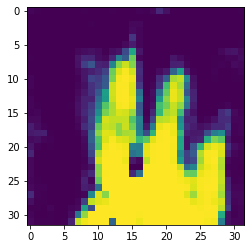

In [9]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

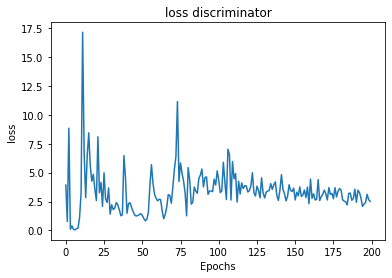

In [10]:
plt.plot(loss_discriminator)
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("loss discriminator")
plt.show()

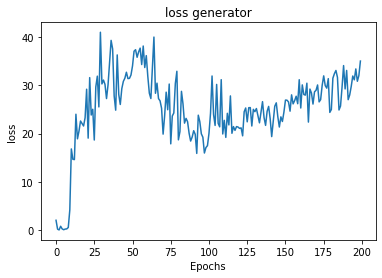

In [11]:
plt.plot(loss_generator)
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("loss generator")
plt.show()

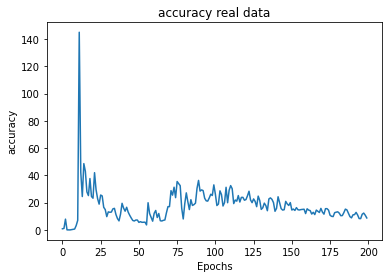

In [12]:
plt.plot(accu_real)
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("accuracy real data")
plt.show()

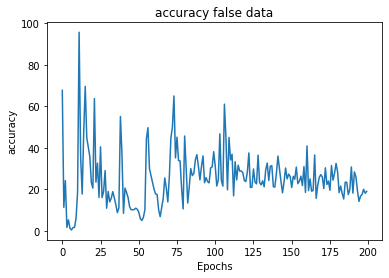

In [13]:
plt.plot(accu_fake)
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("accuracy false data")
plt.show()

# noise and label smoothing

In [16]:
generator = gen()
discriminator = disc()
DCGAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False
DCGAN.compile(optimizer='adam',loss='binary_crossentropy')

In [17]:
epochs = 200
batch_size = 100

iteration = dataset.shape[0]//batch_size

batch = []
for i in range(iteration):
  batch.append(dataset[i*batch_size:(i+1)*batch_size])

loss_discriminator = []
loss_generator = []
accu_real = []
accu_fake = []

True_label = np.ones(shape=(batch_size,1))*(1-0.2)+(0.2/2)
false_label = np.zeros(shape=(batch_size,1))*(1-0.2)+(0.2/2)

for epoch in range(epochs):
  disc_real_data_loss = 0
  disc_fake_data_loss = 0 
  gen_loss = 0
  disc_accu_real = 0
  disc_accu_fake = 0 

  for i in range(iteration):
    True_image = batch[i]
    noise = np.random.normal(size=[batch_size,100])
    false_image = generator.predict_on_batch(noise)

    discriminator.trainable=True
    disc_real_data_loss = disc_real_data_loss + discriminator.train_on_batch(True_image,True_label)
    disc_fake_data_loss = disc_fake_data_loss + discriminator.train_on_batch(false_image,false_label)
    discriminator.trainable=False

    gen_loss = gen_loss +  DCGAN.train_on_batch(noise,True_label)
    disc_accu_real = disc_accu_real + discriminator.evaluate(True_image,True_label,verbose=0)
    disc_accu_fake = disc_accu_fake + discriminator.evaluate(false_image,false_label,verbose=0)
  
  loss_discriminator.append(0.5*(disc_real_data_loss + disc_fake_data_loss))
  loss_generator.append(gen_loss)
  accu_real.append(disc_accu_real*100/iteration)
  accu_fake.append(disc_accu_fake*100/iteration)

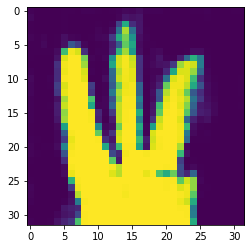

In [18]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

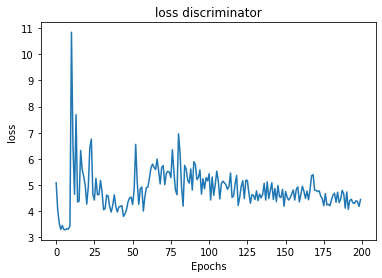

In [19]:
plt.plot(loss_discriminator)
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("loss discriminator")
plt.show()

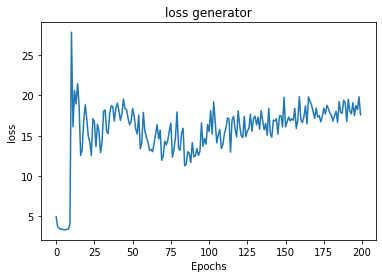

In [20]:
plt.plot(loss_generator)
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("loss generator")
plt.show()

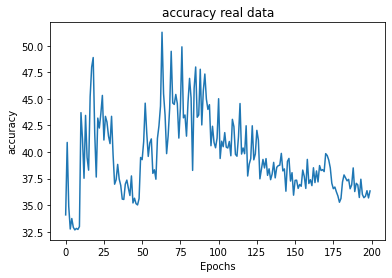

In [21]:
plt.plot(accu_real)
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("accuracy real data")
plt.show()

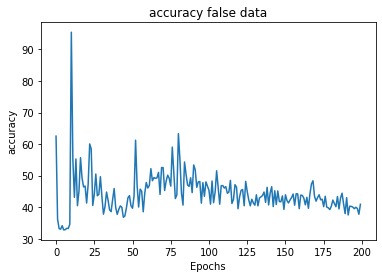

In [22]:
plt.plot(accu_fake)
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("accuracy false data")
plt.show()